### MACHINE LEARNING PROJECT

I'll try to build and train a ML model to predict if a painting is an original paiting from a known artist. I decided to start form a list of 15 artis with a noticeable style difference:
* Andy Warhol
* Caravaggio
* Claude Monet
* Diego Rivera
* Diego Velazquez
* *Edgar Degas (TODO)*
* *Francisco de Goya (TODO)*
* Frida Kahlo
* Gustav Klimt
* Jackson Pollock
* *Joaquín Sorolla (TODO)*
* Katsushika Hokusai
* Pablo Picasso
* Piet Mondrian
* Roy Lichtenstein
* Wassily Kandinsky

I set three objectives:
* Classify if Picasso or Monet
* Classify by *'school' or 'style'*
* Classify by artist

I will use the following characteristics to try to classify the images:
* Dimension ratio
* Filling ratio (white pixels vs. total pixels ratio)
* Chiaroscuro (white pixels vs. black pixels ratio)
* 10 main colors used from a palette of 125

___
### PREREQUISITES

To process images I'll be using OpenCV library. It is important to take a look at the [docs][OpenCV installation and usage] before running the next cell.
For this project I'll use the 'main modules package'

[OpenCV installation and usage]:https://pypi.org/project/opencv-python/

In [10]:
# !pip install opencv-python

In [36]:
### TODO - .yaml

___
### IMPORTS

In [1]:
# Modules used for data handling / test
import os
import time

# from utils import item_to_lists, flatten, mklist, nameof


# Modules used for EDA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.patches import Rectangle


# Modules used for image processing
import cv2

from collections import Counter
# from utils import crop_img, chiaroscuro, extract_img_data, hex_to_rgb
# from utils import fill_ratio, get_img_rgb, reduce_col_palette
# from utils import resize_img, rgb_to_hex, process_color

# Modules used for ML
from sklearn.cluster import KMeans
# from utils import color_quant

In [2]:
# Modules settings
%matplotlib inline

___
### UPDATE UTILS

In [3]:
from utils import item_to_lists, get_collection, show_collection, mklist, nameof
from utils import crop_img, chiaroscuro, extract_img_data, hex_to_rgb
from utils import fill_ratio, get_img_rgb, reduce_col_palette
from utils import resize_img, rgb_to_hex, process_color
from utils import color_quant

In [4]:
# This cell only needs to be executed to update utils
# if modified after them have been imported

%run utils

___
### GETTING IMAGES

In [5]:
path, collection = get_collection('./images/sample_img/', ['.jpg'])

path, collection

('./images/sample_img/',
 ['R&M_01.jpg', 'R&M_02.jpg', 'R&M_03.jpg', 'R&M_04.jpg', 'R&M_05.jpg'])

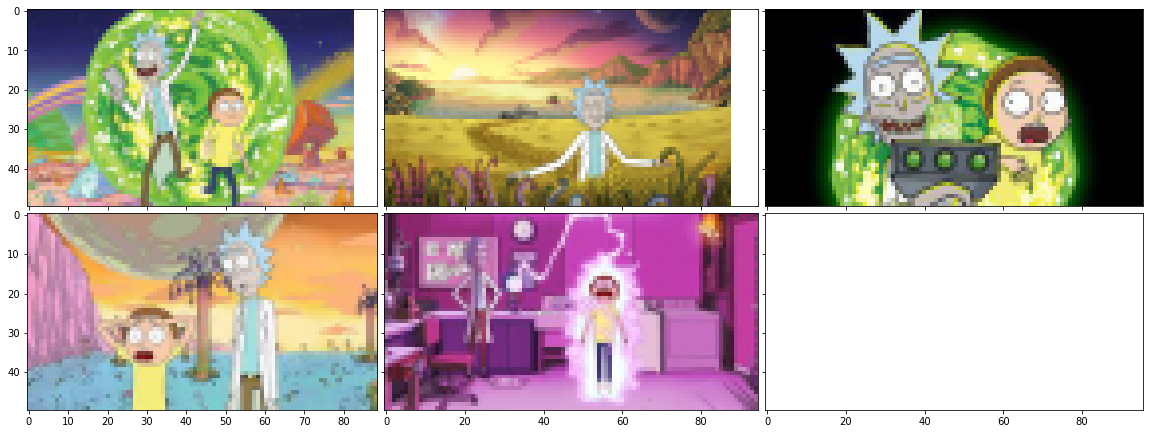

In [6]:
show_collection(path, collection, 3)

___
### IMAGES MANIPULATION

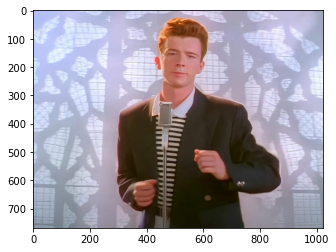

In [7]:
sample = get_img_rgb('./images/sample_img/sample.jpeg')
plt.imshow(sample);

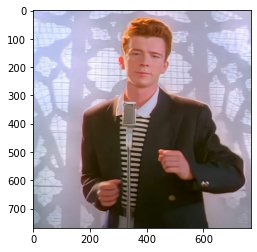

In [8]:
sample = crop_img(sample)
plt.imshow(sample);

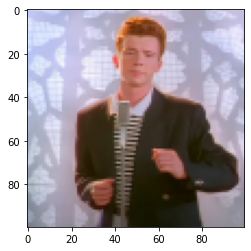

In [9]:
sample = resize_img(sample, 100)
plt.imshow(sample);

Palette reduced to 125 colors.


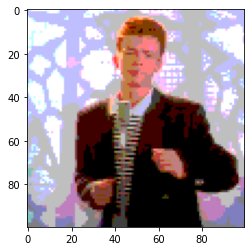

In [10]:
sample = reduce_col_palette(sample, 5, info=True)
plt.imshow(sample);

___
### DATA EXTRACTION

In [23]:
# The data found in each image will be stored in this lists
name, ratio, fill_rt, chi_osc, target = mklist(5)
c_01, c_02, c_03, c_04, c_05, c_06, c_07, c_08, c_09, c_10  = mklist(10)

# To make it easier to add elements to every list, a 'superlist' is created
dset_test = [name, target, ratio, fill_rt, chi_osc,
             c_01, c_02, c_03, c_04, c_05,
             c_06, c_07, c_08, c_09, c_10,]

dset_test

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

In [26]:
colors

['#FFBFFF',
 '#3F0000',
 '#BF7F3F',
 '#BFBFFF',
 '#BFBFBF',
 '#FF7F7F',
 '#FFFFFF',
 '#003F00',
 '#7F3F00',
 '#7F7FBF']

In [27]:
fill_ratio(sample)

87.75

In [28]:
chiaroscuro(sample)

0.054756637168141595

Colors found:


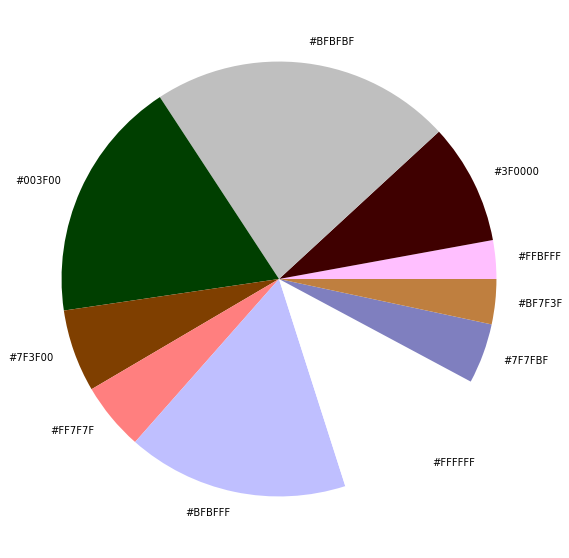

In [29]:
colors, palette = color_quant(sample, 5, num_of_colors=10)

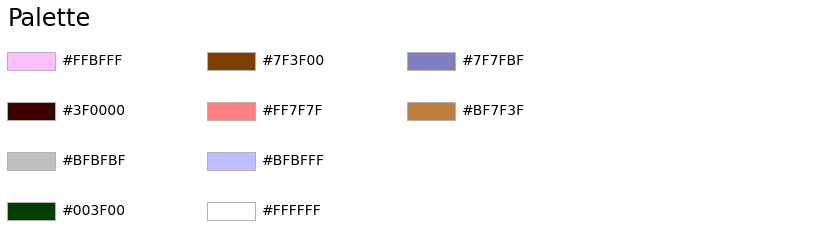

In [32]:
def plot_palette(colors, title, sort_colors=False, emptycols=0):
    cell_width = 200
    cell_height = 50
    swatch_width = 48
    margin = 12
    topmargin = 40

    ### TODO - Sort colors by RGB index
        
    names = list(colors)
    
    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, 
                        margin/height,
                        (width-margin)/width,
                        (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5),
                -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title,
                 fontsize=24,
                 loc="left",
                 pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(Rectangle(xy=(swatch_start_x, y-9),
                               width=swatch_width,
                               height=18,
                               facecolor=colors[name],
                               edgecolor='0.7'))

    return fig

plot_palette(palette, 'Palette',
             sort_colors=True,
             emptycols=1)

plt.show()

In [30]:
errors, errors_log = extract_img_data(path, collection, dset_test, 'Test')

In [31]:
dset_test, errors, errors_log

([['R&M_01',
   'R&M_02',
   'R&M_03',
   'R&M_04',
   'R&M_05',
   'R&M_01',
   'R&M_02',
   'R&M_03',
   'R&M_04',
   'R&M_05'],
  ['Test',
   'Test',
   'Test',
   'Test',
   'Test',
   'Test',
   'Test',
   'Test',
   'Test',
   'Test'],
  [0.6, 0.565, 0.52, 0.56, 0.525, 0.6, 0.565, 0.52, 0.56, 0.525],
  [96.77711,
   98.0452,
   96.65104,
   95.76966,
   93.57368,
   96.77711,
   98.0452,
   96.65104,
   95.76966,
   93.57368],
  [165.0,
   1.85263,
   0.02163,
   88.5,
   2.73913,
   165.0,
   1.85263,
   0.02163,
   88.5,
   2.73913],
  ['#7FBFBF',
   '#BF7F00',
   '#003F00',
   '#FFFFFF',
   '#BF7FBF',
   '#BFBFBF',
   '#FFFFFF',
   '#7FFF3F',
   '#7F7F3F',
   '#FFBFFF'],
  ['#3FBF3F',
   '#FFBF7F',
   '#FFFFBF',
   '#BF7FBF',
   '#3F003F',
   '#00003F',
   '#7F3F3F',
   '#003F00',
   '#FFFFBF',
   '#7F3F7F'],
  ['#00003F',
   '#3F3F00',
   '#7FBF3F',
   '#FFFFBF',
   '#FFFFFF',
   '#7FBF3F',
   '#BFBF3F',
   '#FFFFFF',
   '#BF7FBF',
   '#BF3FBF'],
  ['#FFFFFF',
   '#BF3F7F',
 

___
### DATA EXTRACTION

In [33]:
# The data found in each image will be stored in this lists
name, ratio, fill_rt, chi_osc, target = mklist(5)
c_01, c_02, c_03, c_04, c_05, c_06, c_07, c_08, c_09, c_10  = mklist(10)

# To make it easier to add elements to every list, a 'superlist' is created
paintings_dset = [name, target, ratio, fill_rt, chi_osc,
                  c_01, c_02, c_03, c_04, c_05,
                  c_06, c_07, c_08, c_09, c_10,]

paintings_dset

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

I will create a *collection* for each artist that later on  I will merge into a *museum*

In [34]:
dset_Caravaggio = paintings_dset.copy()
dset_Degas = paintings_dset.copy()
dset_Goya = paintings_dset.copy()
dset_Hokusai = paintings_dset.copy()
dset_Kahlo = paintings_dset.copy()
dset_Kandinsky = paintings_dset.copy()
dset_Klimt = paintings_dset.copy()
dset_Lichtenstein = paintings_dset.copy()
dset_Mondrian = paintings_dset.copy()
dset_Monet = paintings_dset.copy()
dset_Picasso = paintings_dset.copy()
dset_Pollock = paintings_dset.copy()
dset_Rivera = paintings_dset.copy()
dset_Sorolla = paintings_dset.copy()
dset_Velazquez = paintings_dset.copy()
dset_Warhol = paintings_dset.copy()

In [35]:
artists = ['Caravaggio', 'Degas', 'Goya', 'Hokusai', 'Kahlo',
           'Kandinsky', 'Klimt', 'Lichtenstein', 'Mondrian', 'Monet',
           'Picasso', 'Pollock', 'Rivera', 'Sorolla', 'Velazquez',
           'Warhol']